# Cluster Actors using a Matrix of Actor x Genre

Create a matrix of actors and the genres in which they've starred. Then, we'll use k-Means to extract clusters from the data in an unsupervised fashion.

In [3]:
%matplotlib inline


In [4]:
import pandas as pd

import json

In [5]:
actor_name_map = {}
movie_actor_map = {}
actor_genre_map = {}


with open("../data/imdb_movies_2000to2022.prolific.json", "r") as in_file:
    for line in in_file:
        
        # Read the movie on this line and parse its json
        this_movie = json.loads(line)
                    
        # Add all actors to the id->name map
        for actor_id,actor_name in this_movie['actors']:
            actor_name_map[actor_id] = actor_name
            
        # For each actor, add this movie's genres to that actor's list
        for actor_id,actor_name in this_movie['actors']:
            this_actors_genres = actor_genre_map.get(actor_id, {})
            
            # Increment the count of genres for this actor
            for g in this_movie["genres"]:
                this_actors_genres[g] = this_actors_genres.get(g, 0) + 1
                
            # Update the map
            actor_genre_map[actor_id] = this_actors_genres
            
        # Finished with this film
        movie_actor_map[this_movie["imdb_id"]] = ({
            "movie": this_movie["title"],
            "actors": set([item[0] for item in this_movie['actors']]),
            "genres": this_movie["genres"]
        })

In [6]:
# Check the output for actor Mel Gibson, actor ID nm0000154
actor_genre_map['nm0000154']

{'Adventure': 3,
 'Animation': 1,
 'Comedy': 7,
 'Drama': 12,
 'Mystery': 2,
 'Thriller': 10,
 'Action': 11,
 'History': 3,
 'Fantasy': 1,
 'Romance': 1,
 'Sci-Fi': 1,
 'Crime': 5,
 'Musical': 1,
 'Biography': 2}

In [7]:
# Get all actors as an index for a dataframe
index = actor_genre_map.keys()

# Get the genre-counts for each actor in the index
rows = [actor_genre_map[k] for k in index]

# Create the data frame from these rows, with the actors as index
df = pd.DataFrame(rows, index=index)

# Fill NAs with zero, as NA means the actor has not starred in that genre
df = df.fillna(0)

df

,Comedy,Fantasy,Romance,Drama,Mystery,Thriller,Action,Biography,Crime,War,...,Horror,Documentary,Sport,News,Family,Music,,Western,Short,Reality-TV
nm0000212,7.0,1.0,6.0,6.0,1.0,2.0,1.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nm0413168,7.0,3.0,5.0,12.0,5.0,2.0,14.0,4.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nm0000630,8.0,2.0,6.0,14.0,2.0,3.0,4.0,5.0,1.0,1.0,...,3.0,7.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
nm0005227,10.0,1.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
nm0864851,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nm9504284,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nm10592896,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nm7216750,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nm0936300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Apply k-Means with a Fixed K

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [9]:
k = 8 # We pick k=8 for illustrative purposes only. You would need a more principled approach here.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.1

Cluster 0:
nm2034064
nm1451415
nm0001244
nm8909842
nm4312887
Cluster 1:
nm0000329
nm0342029
nm0147147
nm0124930
nm0000102
Cluster 2:
nm0000147
nm0241049
nm1046097
nm0005162
nm0000658
Cluster 3:
nm8904193
nm2445419
nm4442319
nm0549505
nm0534635
Cluster 4:
nm0000160
nm0001845
nm0000553
nm2278431
nm0000514
Cluster 5:
nm0636893
nm3354777
nm0000374
nm3762714
nm0001062
Cluster 6:
nm0000335
nm1318596
nm0005346
nm0258402
nm0005403
Cluster 7:
nm0004999
nm1813221
nm0189200
nm0707399
nm0000947


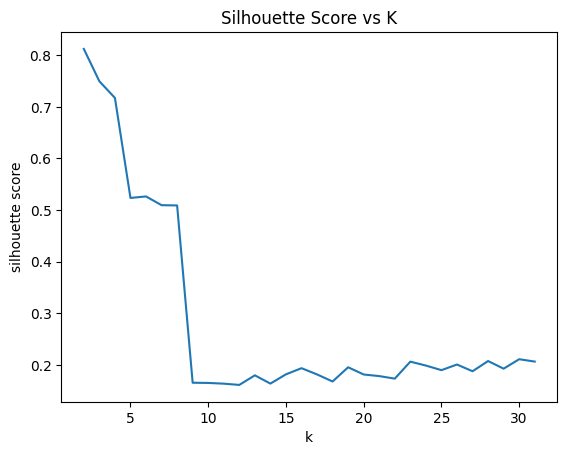

In [14]:
scores = []
for k in range(2, 32):
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(df)
    score = silhouette_score(df, labels)
    scores.append((k, score))

# 3. Plot k vs score    
import matplotlib.pyplot as plt
ks, scores = zip(*scores)
plt.plot(ks, scores)
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette Score vs K')

# 4. Select k and re-fit
k = 8 # selected from elbow
kmeans = KMeans(n_clusters=k).fit(df) 

# 5. Sample actors from each cluster
for i in range(k):
    cluster_df = df[kmeans.labels_==i] 
    print(f'Cluster {i}:') 
    for j in range(5):
        print(cluster_df.sample(1).index[0])